# Barrier Attenuation
When obstacles are positioned between the point source and the receiver in the line-of-sight, these barriers exert a damping effect on the noise perceived by the receiver. As noise rays encounter a barrier, diffraction occurs in the direction of the shortest path around the barrier. The ISO 9613-2 standard provides methods for calculating both lateral and vertical diffraction around barriers. However, since this model specifically incorporates terrain barriers (excluding barrier attenuation from screens or buildings), ISO 17534-3 suggests ignoring lateral diffractions {cite:p}`iso_17534_3`. Additionally, ISO 17534 outlines how higher-order diffractions should be handled, and this approach is integrated into the model. ISO 17534 specifies that the diffraction path should be treated like a tight ribbon extending from the source to the receiver.

<img src="../../jupyter-book/images/diffraction_path.png" alt="diffraction_path" width="400px" class="bg-primary"/>

*Fig 1: Diffraction path from the source to the receiver over multiple barriers (Source: {cite:p}`iso_17534_3`).*

In [25]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.utils import ElevationHandler, calc_diffraction, calc_diffraction_path, print_code
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.display import HTML

## Calculating the diffraction path
The calculation of the diffraction path utilizes a recursive function called `diffraction_recursion`. The process begins with initiating the function using a straight line from the source to the receiver. Subsequently, the algorithm checks if any point along the terrain intersects with this line, indicating a collision between the line-of-sight and the terrain. In case of such a collision, the algorithm identifies the highest elevation difference between the line-of-sight and the terrain, designating the peak of the terrain at this point as a diffraction point. The original line is then split into two segments—one extending from the source to the diffraction point and the other from the diffraction point to the receiver. This recursive process continues until a path is defined from the source to the receiver without any terrain collisions.

In [26]:
HTML(print_code(calc_diffraction))

### Demonstration of code
Here's an example illustrating the calculation of the diffraction path between two points in the terrain.

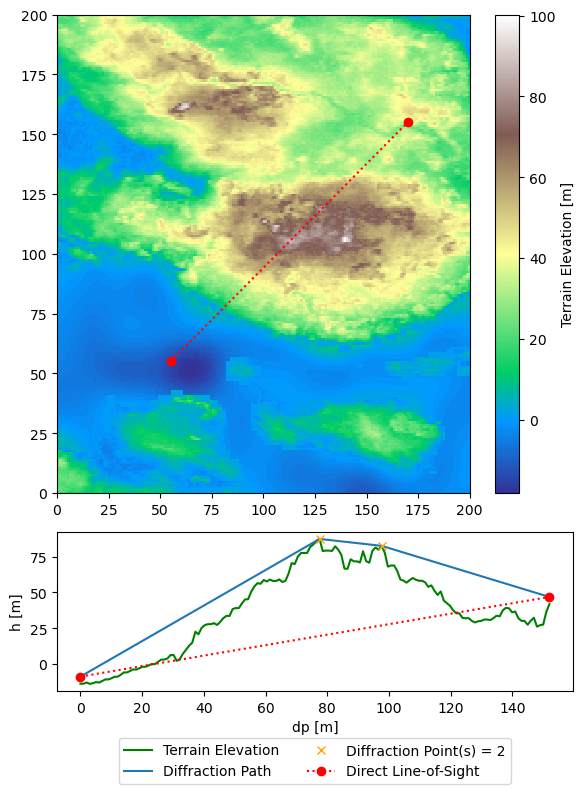

In [28]:
terrain_data = ElevationHandler([11.9, 12.1, 54.9, 55.1], [200, 200]).map_array

start_pixel = (55, 55)
end_pixel = (170, 155)
source_height = 5
receiver_height = 5

length = int(np.hypot(end_pixel[0] - start_pixel[0], end_pixel[1] - start_pixel[1]))
x_coords, y_coords = np.linspace(start_pixel[0], end_pixel[0], length), np.linspace(start_pixel[1], end_pixel[1], length)
distance_points = np.linspace(0, length, length)
elevation_values = terrain_data.T[x_coords.astype(int), y_coords.astype(int)]
diffraction_path = calc_diffraction(source_height, receiver_height, distance_points, elevation_values)

fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6, 8))
terrain_plot = axes[0].pcolormesh(terrain_data, cmap ="terrain")
axes[0].plot([start_pixel[0], end_pixel[0]], [start_pixel[1], end_pixel[1]], 'ro:')
colorbar = fig.colorbar(terrain_plot, ax=axes[0], orientation='vertical', label='Terrain Elevation [m]')
axes[1].plot(distance_points, elevation_values, label="Terrain Elevation", color="green")
axes[1].plot(*diffraction_path.T, label="Diffraction Path")
axes[1].plot(*diffraction_path[1:-1].T, color="orange", marker="x",
             label=f"Diffraction Point(s) = {diffraction_path.shape[0] - 2}", linestyle='None')
axes[1].plot([0, length], [elevation_values[0] + source_height, elevation_values[-1] + receiver_height], 'ro:',
             label="Direct Line-of-Sight")
axes[1].set(xlabel = "dp [m]",
            ylabel = "h [m]")
legend = axes[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()
plt.show()

## Calculation of barrier attenuation
The total attenuation caused by a barrier, denoted as $D_z$, can be computed using the formula:

$$D_z = 10 \log_{10}\left(3 + \left(\frac{C_2}{\lambda}\right) C_3 z K_{met}\right)$$

$\lambda$ represents the sound wavelength, $C_2 = 20$ and is a reflection constant, $C_3$ is a diffraction constant, $z$ is the difference between the path lengths of diffracted and direct sound, calculated as $z = (d_{ss} + e + d_{sr}) - d$, where $e$ represents the distance between the diffraction edges in the case of multiple diffractions. The correction factor for meteorological conditions, $K_{met}$, is defined as:

$$
K_{met} = \exp\left(-\frac{1}{2000} \sqrt{\frac{d_{ss} \cdot d_{sr} \cdot d}{2 z}}\right)
$$

The diffraction constant $C_3$ is defined as:

$$
C_3 = \begin{cases}
1 & \text{if } e \leq 0\\
\frac{1 + \left(\frac{5 \cdot \lambda}{e}\right)^2}{\frac{1}{3} + \left(\frac{5 \cdot \lambda}{e}\right)^2} & \text{if } e > 0
\end{cases}
$$

### Visualization of Diffraction Length
Presented below is a concise visualization illustrating the disparity between the direct path and the diffraction path. It's crucial to observe that when these two distances diverge, the noise is anticipated to intersect with the terrain, and barrier attenuation is factored into the calculation for the sound pressure level at that location. Conversely, if the diffraction path and direct path align, indicating no collision with the terrain, the barrier attenuation is disregarded.

In [32]:
map_boundaries = [11.9, 12.1, 54.9, 55.1]
map_shape = [100, 100]
elevation_handler = ElevationHandler(map_boundaries, map_shape)

point_source_data = pd.DataFrame(data=[{
        "latitude": 55,
        "longitude": 12,
        "h": 20}]).iloc[0]

map_shape = [200, 200]

dp, d, dss, dsr, e = calc_diffraction_path(elevation_handler, point_source_data)

diff_path = dsr+dss+e
diff_path[diff_path == 0] = d[diff_path == 0]

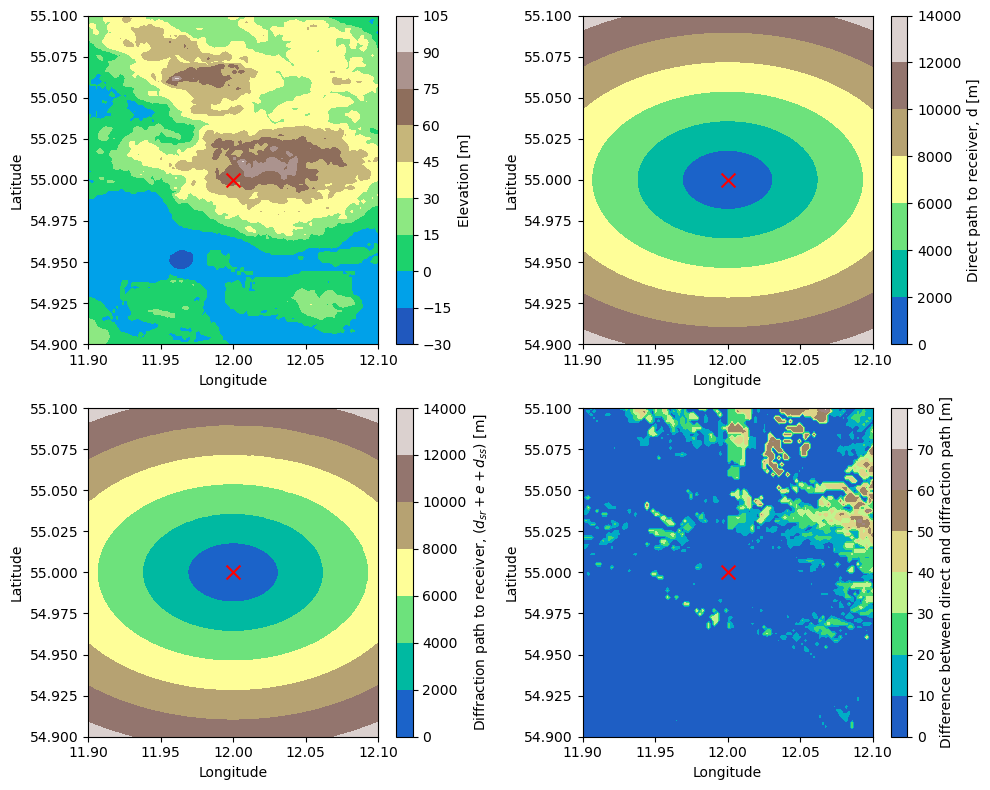

In [39]:
fig, axes = plt.subplots(2,2, figsize=(10, 8))
pcm1 = axes[0, 0].contourf(elevation_handler.long_range, elevation_handler.lat_range, elevation_handler.map_array, cmap = "terrain")
plt.colorbar(pcm1, ax = axes[0,0], label = "Elevation [m]")
axes[0, 0].scatter(point_source_data.longitude, point_source_data.latitude, marker = "x", color = "red", s = 100)

pcm2 = axes[0, 1].contourf(elevation_handler.long_range, elevation_handler.lat_range, d, cmap = "terrain")
plt.colorbar(pcm2, ax = axes[0, 1], label = "Direct path to receiver, d [m]")
axes[0, 1].scatter(point_source_data.longitude, point_source_data.latitude, marker = "x", color = "red", s = 100)

pcm3 = axes[1, 0].contourf(elevation_handler.long_range, elevation_handler.lat_range, diff_path, cmap = "terrain")
plt.colorbar(pcm3, ax = axes[1, 0], label = r"Diffraction path to receiver, ($d_{sr} + e + d_{ss}$) [m]")
axes[1, 0].scatter(point_source_data.longitude, point_source_data.latitude, marker = "x", color = "red", s = 100)

pcm4 = axes[1, 1].contourf(elevation_handler.long_range, elevation_handler.lat_range, (diff_path-d), cmap = "terrain")
plt.colorbar(pcm4, ax = axes[1, 1], label = "Difference between direct and diffraction path [m]")
axes[1, 1].scatter(point_source_data.longitude, point_source_data.latitude, marker = "x", color = "red", s = 100)


for ax in axes.flatten():
    ax.set(xlabel = "Longitude",
           ylabel = "Latitude")
    
plt.tight_layout()
plt.show()

### Meteorological conditions
Here is a brief illustration showcasing the impact of meteorological conditions through the correction factor $K_{met}$ for various barrier heights ($h$) positioned between the sound source and the receiver. When the diffraction path and the direct path are equal ($z \leq 0$), the correction factor is equal to $K_{met} = 1$.

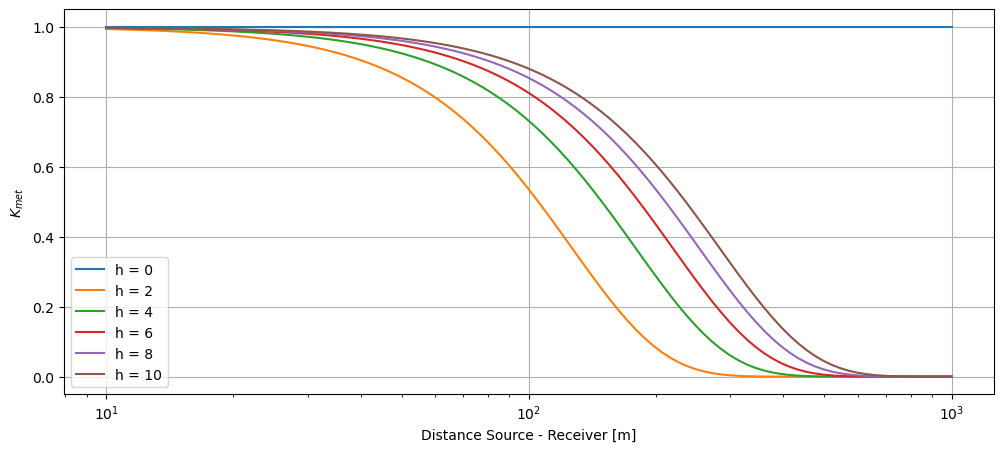

In [52]:
hb = np.arange(0, 12, 2) # height barrier relative to source and receiver
d = np.logspace(np.log10(10), np.log10(1000), 100)

fig, ax = plt.subplots(figsize = (12,5))
for i, h in enumerate(hb):
    dss = np.hypot(d/2, h)
    dsr = dss
    z = (dsr + dss) - d
    mask = z <= 0
    Kmet = np.exp(-(1/2000) * np.sqrt((dss * dsr * d)/(2 * z)))
    Kmet[mask] = 1
    ax.semilogx(d, Kmet, label = f"h = {h}")
ax.legend()
ax.grid()
ax.set(xlabel = "Distance Source - Receiver [m]",
       ylabel = r"$K_{met}$")
plt.show()

As evident from the above plot, the meteorological correction factor significantly decreases at longer distances $d$ between the source and the receiver. This results in a notable limitation of the barrier attenuation to $D_z = 10 \log_{10}(3)$ for distances exceeding 1000 meters between the source and the receiver.